# Method 4 - Best Ideas Medium Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Market Cap Adjusted Target

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance Adjusted Intra-Cap Weight Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data[
    'weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['size_pct'] > (1 / 3)) & (best_ideas['size_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

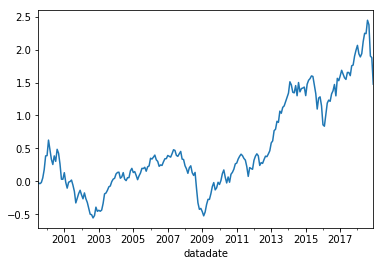

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.386750
2000-12-31   -0.255561
2001-12-31   -0.161873
2002-12-31   -0.369587
2003-12-31    0.920192
2004-12-31    0.143254
2005-12-31    0.030996
2006-12-31    0.089438
2007-12-31   -0.009771
2008-12-31   -0.557060
2009-12-31    0.672010
2010-12-31    0.283075
2011-12-31   -0.064804
2012-12-31    0.237006
2013-12-31    0.550716
2014-12-31    0.070665
2015-12-31   -0.117307
2016-12-31    0.178057
2017-12-31    0.182833
2018-12-31   -0.172099
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     525.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.03e-114
Time:                        12:05:21   Log-Likelihood:                 543.50
No. Observations:                 234   AIC:                            -1077.
Df Residuals:                     229   BIC:                            -1060.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.762      0.079      -0.000       0.006
mktrf          1.1412      0.045     25.522      0.000       1.053       1.229
me             0.4965      0.052      9.545      0.000       0.394       0.599
ia            -0.0323      0.079     -0.409      0.683      -0.188       0.123
roe           -0.6997      0.068    -10.341      0.000      -0.833      -0.566
==============================================================================
Omnibus:                       33.193   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.145
Skew:                           0.514   Prob(JB):                     1.64e-25
Kurtosis:                       6.264   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     611.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.34e-121
Time:                        12:05:21   Log-Likelihood:                 543.50
No. Observations:                 234   AIC:                            -1077.
Df Residuals:                     229   BIC:                            -1060.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.437      0.151      -0.001       0.007
mktrf          1.1412      0.037     30.457      0.000       1.068       1.215
me             0.4965      0.056      8.830      0.000       0.386       0.607
ia            -0.0323      0.124     -0.261      0.794      -0.275       0.211
roe           -0.6997      0.129     -5.418      0.000      -0.953      -0.447
==============================================================================
Omnibus:                       33.193   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.145
Skew:                           0.514   Prob(JB):                     1.64e-25
Kurtosis:                       6.264   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     851.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.52e-136
Time:                        12:05:21   Log-Likelihood:                 543.50
No. Observations:                 234   AIC:                            -1077.
Df Residuals:                     229   BIC:                            -1060.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.524      0.127      -0.001       0.007
mktrf          1.1412      0.034     33.154      0.000       1.074       1.209
me             0.4965      0.060      8.282      0.000       0.379       0.614
ia            -0.0323      0.111     -0.291      0.771      -0.250       0.185
roe           -0.6997      0.134     -5.208      0.000      -0.963      -0.436
==============================================================================
Omnibus:                       33.193   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.145
Skew:                           0.514   Prob(JB):                     1.64e-25
Kurtosis:                       6.264   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     376.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.82e-108
Time:                        12:05:21   Log-Likelihood:                 532.40
No. Observations:                 234   AIC:                            -1053.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      1.212      0.227      -0.001       0.006
mktrf          1.2249      0.047     26.018      0.000       1.132       1.318
smb            0.5235      0.062      8.427      0.000       0.401       0.646
hml            0.0023      0.073      0.032      0.975      -0.142       0.147
rmw           -0.6240      0.083     -7.535      0.000      -0.787      -0.461
cma            0.1175      0.105      1.116      0.265      -0.090       0.325
==============================================================================
Omnibus:                       23.650   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.273
Skew:                           0.439   Prob(JB):                     3.66e-13
Kurtosis:                       5.259   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     268.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.41e-93
Time:                        12:05:21   Log-Likelihood:                 532.40
No. Observations:                 234   AIC:                            -1053.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      1.114      0.265      -0.002       0.006
mktrf          1.2249      0.051     24.144      0.000       1.125       1.324
smb            0.5235      0.083      6.345      0.000       0.362       0.685
hml            0.0023      0.126      0.019      0.985      -0.244       0.249
rmw           -0.6240      0.144     -4.337      0.000      -0.906      -0.342
cma            0.1175      0.160      0.735      0.463      -0.196       0.431
==============================================================================
Omnibus:                       23.650   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.273
Skew:                           0.439   Prob(JB):                     3.66e-13
Kurtosis:                       5.259   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     277.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.90e-95
Time:                        12:05:21   Log-Likelihood:                 532.40
No. Observations:                 234   AIC:                            -1053.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      1.176      0.240      -0.001       0.006
mktrf          1.2249      0.051     24.094      0.000       1.125       1.325
smb            0.5235      0.079      6.631      0.000       0.369       0.678
hml            0.0023      0.107      0.022      0.983      -0.207       0.212
rmw           -0.6240      0.150     -4.150      0.000      -0.919      -0.329
cma            0.1175      0.137      0.860      0.390      -0.150       0.385
==============================================================================
Omnibus:                       23.650   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.273
Skew:                           0.439   Prob(JB):                     3.66e-13
Kurtosis:                       5.259   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     406.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.01e-102
Time:                        12:05:21   Log-Likelihood:                 516.65
No. Observations:                 234   AIC:                            -1023.
Df Residuals:                     229   BIC:                            -1006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.174      0.862      -0.003       0.004
mktrf          1.2814      0.046     27.752      0.000       1.190       1.372
smb            0.7778      0.058     13.495      0.000       0.664       0.891
hml           -0.0653      0.057     -1.141      0.255      -0.178       0.048
umd           -0.1942      0.038     -5.169      0.000      -0.268      -0.120
==============================================================================
Omnibus:                       42.412   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.747
Skew:                           0.724   Prob(JB):                     3.33e-30
Kurtosis:                       6.439   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     463.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.60e-108
Time:                        12:05:21   Log-Likelihood:                 516.65
No. Observations:                 234   AIC:                            -1023.
Df Residuals:                     229   BIC:                            -1006.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.156      0.876      -0.004       0.004
mktrf          1.2814      0.043     29.560      0.000       1.196       1.366
smb            0.7778      0.062     12.587      0.000       0.657       0.899
hml           -0.0653      0.091     -0.718      0.473      -0.244       0.113
umd           -0.1942      0.076     -2.546      0.011      -0.344      -0.045
==============================================================================
Omnibus:                       42.412   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.747
Skew:                           0.724   Prob(JB):                     3.33e-30
Kurtosis:                       6.439   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     468.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.04e-109
Time:                        12:05:21   Log-Likelihood:                 516.65
No. Observations:                 234   AIC:                            -1023.
Df Residuals:                     229   BIC:                            -1006.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.168      0.867      -0.003       0.004
mktrf          1.2814      0.044     29.193      0.000       1.195       1.367
smb            0.7778      0.062     12.587      0.000       0.657       0.899
hml           -0.0653      0.083     -0.787      0.431      -0.228       0.097
umd           -0.1942      0.080     -2.438      0.015      -0.350      -0.038
==============================================================================
Omnibus:                       42.412   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.747
Skew:                           0.724   Prob(JB):                     3.33e-30
Kurtosis:                       6.439   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     264.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.28e-57
Time:                        12:05:21   Log-Likelihood:                 260.63
No. Observations:                 120   AIC:                            -511.3
Df Residuals:                     115   BIC:                            -497.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.003      1.522      0.131      -0.001       0.009
mktrf          1.1641      0.073     16.034      0.000       1.020       1.308
me             0.4310      0.072      6.010      0.000       0.289       0.573
ia            -0.0520      0.112     -0.463      0.644      -0.274       0.170
roe           -0.6810      0.099     -6.852      0.000      -0.878      -0.484
==============================================================================
Omnibus:                       16.018   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.144
Skew:                           0.415   Prob(JB):                     1.16e-09
Kurtosis:                       5.746   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     343.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.51e-63
Time:                        12:05:21   Log-Likelihood:                 260.63
No. Observations:                 120   AIC:                            -511.3
Df Residuals:                     115   BIC:                            -497.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.004      1.153      0.249      -0.003       0.011
mktrf          1.1641      0.056     20.957      0.000       1.055       1.273
me             0.4310      0.067      6.450      0.000       0.300       0.562
ia            -0.0520      0.180     -0.289      0.773      -0.405       0.301
roe           -0.6810      0.181     -3.757      0.000      -1.036      -0.326
==============================================================================
Omnibus:                       16.018   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.144
Skew:                           0.415   Prob(JB):                     1.16e-09
Kurtosis:                       5.746   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     505.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.65e-72
Time:                        12:05:21   Log-Likelihood:                 260.63
No. Observations:                 120   AIC:                            -511.3
Df Residuals:                     115   BIC:                            -497.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.003      1.207      0.227      -0.003       0.011
mktrf          1.1641      0.052     22.224      0.000       1.061       1.267
me             0.4310      0.071      6.032      0.000       0.291       0.571
ia            -0.0520      0.163     -0.319      0.750      -0.372       0.268
roe           -0.6810      0.187     -3.633      0.000      -1.048      -0.314
==============================================================================
Omnibus:                       16.018   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.144
Skew:                           0.415   Prob(JB):                     1.16e-09
Kurtosis:                       5.746   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     201.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.55e-55
Time:                        12:05:21   Log-Likelihood:                 258.40
No. Observations:                 120   AIC:                            -504.8
Df Residuals:                     114   BIC:                            -488.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.003      1.720      0.088      -0.001       0.010
mktrf          1.3122      0.078     16.751      0.000       1.157       1.467
smb            0.4506      0.089      5.079      0.000       0.275       0.626
hml           -0.0923      0.109     -0.849      0.397      -0.308       0.123
rmw           -0.5593      0.128     -4.363      0.000      -0.813      -0.305
cma            0.1959      0.140      1.395      0.166      -0.082       0.474
==============================================================================
Omnibus:                        9.772   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               13.435
Skew:                           0.423   Prob(JB):                      0.00121
Kurtosis:                       4.404   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     233.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.52e-58
Time:                        12:05:21   Log-Likelihood:                 258.40
No. Observations:                 120   AIC:                            -504.8
Df Residuals:                     114   BIC:                            -488.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.003      1.633      0.103      -0.001       0.011
mktrf          1.3122      0.085     15.524      0.000       1.147       1.478
smb            0.4506      0.103      4.390      0.000       0.249       0.652
hml           -0.0923      0.172     -0.538      0.591      -0.429       0.244
rmw           -0.5593      0.210     -2.663      0.008      -0.971      -0.148
cma            0.1959      0.186      1.055      0.291      -0.168       0.560
==============================================================================
Omnibus:                        9.772   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               13.435
Skew:                           0.423   Prob(JB):                      0.00121
Kurtosis:                       4.404   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     368.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-68
Time:                        12:05:21   Log-Likelihood:                 258.40
No. Observations:                 120   AIC:                            -504.8
Df Residuals:                     114   BIC:                            -488.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.003      1.711      0.087      -0.001       0.010
mktrf          1.3122      0.084     15.545      0.000       1.147       1.478
smb            0.4506      0.092      4.921      0.000       0.271       0.630
hml           -0.0923      0.166     -0.556      0.578      -0.418       0.233
rmw           -0.5593      0.224     -2.500      0.012      -0.998      -0.121
cma            0.1959      0.154      1.276      0.202      -0.105       0.497
==============================================================================
Omnibus:                        9.772   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               13.435
Skew:                           0.423   Prob(JB):                      0.00121
Kurtosis:                       4.404   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     217.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-52
Time:                        12:05:21   Log-Likelihood:                 250.15
No. Observations:                 120   AIC:                            -490.3
Df Residuals:                     115   BIC:                            -476.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.003      0.925      0.357      -0.003       0.008
mktrf          1.3706      0.070     19.637      0.000       1.232       1.509
smb            0.6990      0.079      8.796      0.000       0.542       0.856
hml           -0.1406      0.080     -1.766      0.080      -0.298       0.017
umd           -0.1569      0.049     -3.197      0.002      -0.254      -0.060
==============================================================================
Omnibus:                       23.644   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.781
Skew:                           0.765   Prob(JB):                     3.46e-12
Kurtosis:                       5.867   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     413.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.06e-67
Time:                        12:05:21   Log-Likelihood:                 250.15
No. Observations:                 120   AIC:                            -490.3
Df Residuals:                     115   BIC:                            -476.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.003      0.858      0.391      -0.003       0.009
mktrf          1.3706      0.043     31.923      0.000       1.286       1.455
smb            0.6990      0.077      9.041      0.000       0.547       0.851
hml           -0.1406      0.116     -1.217      0.224      -0.367       0.086
umd           -0.1569      0.087     -1.810      0.070      -0.327       0.013
==============================================================================
Omnibus:                       23.644   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.781
Skew:                           0.765   Prob(JB):                     3.46e-12
Kurtosis:                       5.867   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     539.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.79e-73
Time:                        12:05:21   Log-Likelihood:                 250.15
No. Observations:                 120   AIC:                            -490.3
Df Residuals:                     115   BIC:                            -476.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.003      0.930      0.353      -0.003       0.008
mktrf          1.3706      0.034     40.373      0.000       1.304       1.437
smb            0.6990      0.078      8.994      0.000       0.547       0.851
hml           -0.1406      0.113     -1.240      0.215      -0.363       0.082
umd           -0.1569      0.087     -1.809      0.070      -0.327       0.013
==============================================================================
Omnibus:                       23.644   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.781
Skew:                           0.765   Prob(JB):                     3.46e-12
Kurtosis:                       5.867   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     270.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.40e-55
Time:                        12:05:21   Log-Likelihood:                 296.34
No. Observations:                 114   AIC:                            -582.7
Df Residuals:                     109   BIC:                            -569.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.488      0.140      -0.001       0.006
mktrf          1.0701      0.054     19.792      0.000       0.963       1.177
me             0.7041      0.083      8.434      0.000       0.539       0.870
ia            -0.0242      0.116     -0.209      0.835      -0.254       0.205
roe           -0.7347      0.102     -7.222      0.000      -0.936      -0.533
==============================================================================
Omnibus:                       18.062   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.826
Skew:                           0.805   Prob(JB):                     4.07e-06
Kurtosis:                       4.623   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     539.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.75e-71
Time:                        12:05:21   Log-Likelihood:                 296.34
No. Observations:                 114   AIC:                            -582.7
Df Residuals:                     109   BIC:                            -569.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      1.930      0.054   -4.17e-05       0.005
mktrf          1.0701      0.046     23.039      0.000       0.979       1.161
me             0.7041      0.053     13.295      0.000       0.600       0.808
ia            -0.0242      0.113     -0.215      0.830      -0.245       0.196
roe           -0.7347      0.105     -7.013      0.000      -0.940      -0.529
==============================================================================
Omnibus:                       18.062   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.826
Skew:                           0.805   Prob(JB):                     4.07e-06
Kurtosis:                       4.623   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     753.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-78
Time:                        12:05:21   Log-Likelihood:                 296.34
No. Observations:                 114   AIC:                            -582.7
Df Residuals:                     109   BIC:                            -569.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.132      0.033       0.000       0.005
mktrf          1.0701      0.041     26.368      0.000       0.991       1.150
me             0.7041      0.052     13.491      0.000       0.602       0.806
ia            -0.0242      0.110     -0.220      0.826      -0.239       0.191
roe           -0.7347      0.092     -7.972      0.000      -0.915      -0.554
==============================================================================
Omnibus:                       18.062   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.826
Skew:                           0.805   Prob(JB):                     4.07e-06
Kurtosis:                       4.623   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     178.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-50
Time:                        12:05:21   Log-Likelihood:                 286.88
No. Observations:                 114   AIC:                            -561.8
Df Residuals:                     108   BIC:                            -545.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.343      0.732      -0.003       0.005
mktrf          1.1224      0.056     19.941      0.000       1.011       1.234
smb            0.7127      0.091      7.799      0.000       0.532       0.894
hml            0.0876      0.117      0.752      0.454      -0.143       0.319
rmw           -0.6298      0.143     -4.413      0.000      -0.913      -0.347
cma            0.0445      0.181      0.246      0.806      -0.315       0.404
==============================================================================
Omnibus:                        6.817   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.564
Skew:                           0.465   Prob(JB):                       0.0376
Kurtosis:                       3.719   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     141.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-45
Time:                        12:05:21   Log-Likelihood:                 286.88
No. Observations:                 114   AIC:                            -561.8
Df Residuals:                     108   BIC:                            -545.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.361      0.718      -0.003       0.004
mktrf          1.1224      0.060     18.729      0.000       1.005       1.240
smb            0.7127      0.074      9.595      0.000       0.567       0.858
hml            0.0876      0.140      0.625      0.532      -0.187       0.362
rmw           -0.6298      0.215     -2.936      0.003      -1.050      -0.209
cma            0.0445      0.174      0.257      0.797      -0.296       0.385
==============================================================================
Omnibus:                        6.817   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.564
Skew:                           0.465   Prob(JB):                       0.0376
Kurtosis:                       3.719   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     183.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.86e-51
Time:                        12:05:21   Log-Likelihood:                 286.88
No. Observations:                 114   AIC:                            -561.8
Df Residuals:                     108   BIC:                            -545.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.363      0.717      -0.003       0.004
mktrf          1.1224      0.062     17.993      0.000       1.000       1.245
smb            0.7127      0.070     10.179      0.000       0.575       0.850
hml            0.0876      0.142      0.616      0.538      -0.191       0.366
rmw           -0.6298      0.213     -2.961      0.003      -1.047      -0.213
cma            0.0445      0.183      0.243      0.808      -0.314       0.403
==============================================================================
Omnibus:                        6.817   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.564
Skew:                           0.465   Prob(JB):                       0.0376
Kurtosis:                       3.719   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     197.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.41e-49
Time:                        12:05:22   Log-Likelihood:                 280.44
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     109   BIC:                            -537.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.086      0.931      -0.004       0.004
mktrf          1.1449      0.059     19.438      0.000       1.028       1.262
smb            0.8595      0.092      9.358      0.000       0.677       1.042
hml            0.1535      0.095      1.623      0.107      -0.034       0.341
umd           -0.1978      0.071     -2.771      0.007      -0.339      -0.056
==============================================================================
Omnibus:                       11.283   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.069
Skew:                           0.521   Prob(JB):                     0.000534
Kurtosis:                       4.445   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     186.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.73e-48
Time:                        12:05:22   Log-Likelihood:                 280.44
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     109   BIC:                            -537.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.102      0.918      -0.003       0.004
mktrf          1.1449      0.057     19.942      0.000       1.032       1.257
smb            0.8595      0.076     11.331      0.000       0.711       1.008
hml            0.1535      0.140      1.097      0.273      -0.121       0.428
umd           -0.1978      0.058     -3.381      0.001      -0.312      -0.083
==============================================================================
Omnibus:                       11.283   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.069
Skew:                           0.521   Prob(JB):                     0.000534
Kurtosis:                       4.445   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     187.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.11e-48
Time:                        12:05:22   Log-Likelihood:                 280.44
No. Observations:                 114   AIC:                            -550.9
Df Residuals:                     109   BIC:                            -537.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.101      0.919      -0.003       0.004
mktrf          1.1449      0.055     20.923      0.000       1.038       1.252
smb            0.8595      0.058     14.801      0.000       0.746       0.973
hml            0.1535      0.142      1.078      0.281      -0.126       0.433
umd           -0.1978      0.048     -4.077      0.000      -0.293      -0.103
==============================================================================
Omnibus:                       11.283   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.069
Skew:                           0.521   Prob(JB):                     0.000534
Kurtosis:                       4.445   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""